In [153]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import clip

from sklearn.metrics import accuracy_score, f1_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Download Dataset**

Download the dataset from [this Kaggle link](https://www.kaggle.com/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp) and unzip it under your project folder


The entire possible answers form the answer space and the model answer questioned image by classifying the answer from answer space.


In [146]:
# load dataset
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("..","dataset","data_train.csv"),
        "test": os.path.join("..","dataset", "data_eval.csv")
    }
)

with open(os.path.join("..","dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

image575


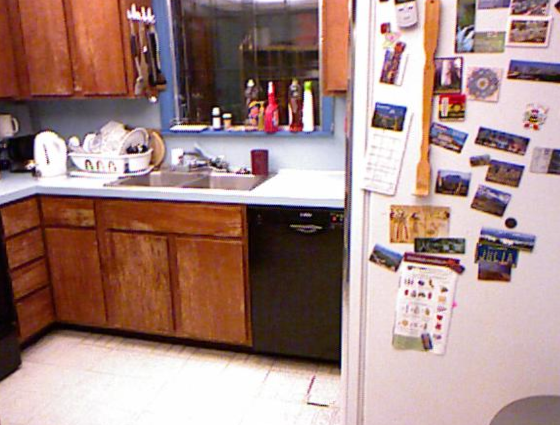

Question:	 what is the largest black object in the kitchen
Answer:		 dishwasher (Label: 166)


In [147]:
# show instance of dataset
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    print(data[id]["image_id"])
    image = Image.open(os.path.join("..","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

showExample()

**Constructing Model**

In [148]:
import torch
import torch.nn as nn
import clip
from transformers import AutoTokenizer, RobertaModel

class SimpleBaselineNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleBaselineNet, self).__init__()
        self.clip_model, self.preprocess = clip.load('ViT-B/32', device='cuda', jit=False)
        
        # Freeze parameters of the image encoder
        for param in self.clip_model.visual.parameters():
            param.requires_grad = False
        
        # Freeze parameters of the text encoder
        for param in self.clip_model.transformer.parameters():
            param.requires_grad = False

        # Freeze other parameters
        for param in [
            self.clip_model.positional_embedding,
            self.clip_model.text_projection,
            self.clip_model.logit_scale,
            self.clip_model.token_embedding.weight,
            self.clip_model.ln_final.weight,
            self.clip_model.ln_final.bias
        ]:
            param.requires_grad = False
        
        self.classifier = nn.Linear(512*2, num_classes)

    def forward(self, image, question, device='cuda'):
        # Preprocess and encode image
        image = self.preprocess(image).unsqueeze(0).to(device)
        image_features = self.clip_model.encode_image(image)

        # Tokenize and encode text
        text = clip.tokenize(question).to(device)
        text_features = self.clip_model.encode_text(text)

        # Concatenate features and classify
        concatenated_features = torch.cat((text_features, image_features), dim=1).to(torch.float32)
        logits = self.classifier(concatenated_features)
        return logits



In [158]:
class Baseline():
    def __init__(self, dataset, batch_size, num_epochs, lr=0.001, num_classes = 582):
        self.num_classes = num_classes
        
        self.model = SimpleBaselineNet(num_classes)
        
        self._num_epochs = num_epochs
        self._batch_size = batch_size
        self._lr = lr

        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.DEVICE)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.initialize_weights()

        scheduler = StepLR(self.optimizer, step_size=10, gamma=0.6)
        
        self.train_dataset_loader = DataLoader(dataset["train"], batch_size=1, shuffle=True)
        self.val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)
    
    def initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def train(self):
        print('Started Training.\n')
        best_prec = 0.0
        for epoch in range(self._num_epochs):
            self.model.train()  # Set the model to training mode
            train_loss = 0.0
            for batch_id, batch in enumerate(self.train_dataset_loader):
                image_id = batch['image_id'][0]
                labels = batch['label']

                true_answer = torch.zeros(1, self.num_classes, dtype=torch.float32)
                for label in labels:
                    true_answer[0][label] = 1

                true_answer = true_answer.to(self.DEVICE)
                
                question = batch['question']
                image = Image.open(os.path.join("..","dataset", "images", image_id + ".png"))

                predicted_answer = self.model(image, question)

                self.optimizer.zero_grad()
                loss = self.criterion(predicted_answer, true_answer)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                if batch_id % 100 == 0:  # Log every 100 batches
                    print(f'Epoch [{epoch+1}/{self._num_epochs}], Step [{batch_id}/{len(self.train_dataset_loader)}], Loss: {loss.item():.4f}')

            scheduler.step()

            # Print the current learning rate
            print(f"Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()}")

        model_name = f"baseline_{self._num_epochs}_{self._lr}_{self._batch_size}.pth"  # Adjust the format of the model name as needed
        torch.save(self.model.state_dict(), model_name)
        print('Finished Training.')

**Training**

In [159]:
epochs = [10, 20, 30, 40, 50]
for epoch in epochs:
    model = Baseline(dataset, batch_size=1, num_epochs=epoch, lr=0.001)
    model.train()

Started Training.

Epoch [1/10], Step [0/9974], Loss: 7.3924
Epoch [1/10], Step [100/9974], Loss: 9.1802
Epoch [1/10], Step [200/9974], Loss: 10.1670
Epoch [1/10], Step [300/9974], Loss: 11.2403
Epoch [1/10], Step [400/9974], Loss: 12.1009
Epoch [1/10], Step [500/9974], Loss: 11.9220
Epoch [1/10], Step [600/9974], Loss: 7.0877
Epoch [1/10], Step [700/9974], Loss: 7.1283
Epoch [1/10], Step [800/9974], Loss: 4.3857
Epoch [1/10], Step [900/9974], Loss: 12.9479
Epoch [1/10], Step [1000/9974], Loss: 3.4959
Epoch [1/10], Step [1100/9974], Loss: 5.3840
Epoch [1/10], Step [1200/9974], Loss: 3.9646
Epoch [1/10], Step [1300/9974], Loss: 2.4627
Epoch [1/10], Step [1400/9974], Loss: 3.7946
Epoch [1/10], Step [1500/9974], Loss: 4.5140
Epoch [1/10], Step [1600/9974], Loss: 13.8338
Epoch [1/10], Step [1700/9974], Loss: 4.2373
Epoch [1/10], Step [1800/9974], Loss: 6.2842
Epoch [1/10], Step [1900/9974], Loss: 7.0172
Epoch [1/10], Step [2000/9974], Loss: 9.2316
Epoch [1/10], Step [2100/9974], Loss: 2.37

NameError: name 'scheduler' is not defined

**Testing**

In [50]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, threshold, epoch):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question']
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()

            predicted_probs = torch.softmax(predicted_logits)
            predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities

            for j in range (0, len(predicted_labels[0])):
                if predicted_labels[0][j] == 1:
                    if j in labels:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if j in labels:
                        FN += 1
                    else:
                        TN += 1

            total_matches += ((predicted_labels == true_answer).sum()).item()
            total_samples += len(labels)

            pbar.update(1)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0

    print(f'Epoch: {epoch}, threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')

num_classes = 582
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=True)

epochs = [10, 20, 30, 40]
thresholds = [0.5, 0.7, 0.9]
for epoch in epochs:
    
    baseline = SimpleBaselineNet(num_classes)
    
    model_name = f"baseline_{epoch}_{0.001}_{1}.pth"
    baseline.load_state_dict(torch.load(model_name))
    baseline.to(device)  

    for threshold in thresholds:
        validate(baseline, val_dataset_loader, device, num_classes, threshold, epoch)

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:34<00:00, 16.11it/s]


Epoch: 10, threshold: 0.50
Precision: 0.0117, Recall: 0.1680
F1 Score: 0.0218, Accuracy: 0.9741


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:38<00:00, 15.71it/s]


Epoch: 10, threshold: 0.70
Precision: 0.0129, Recall: 0.1219
F1 Score: 0.0233, Accuracy: 0.9824


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:36<00:00, 15.91it/s]


Epoch: 10, threshold: 0.90
Precision: 0.0125, Recall: 0.0573
F1 Score: 0.0205, Accuracy: 0.9906


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:35<00:00, 16.01it/s]


Epoch: 20, threshold: 0.50
Precision: 0.0039, Recall: 0.2598
F1 Score: 0.0078, Accuracy: 0.8857


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:33<00:00, 16.21it/s]


Epoch: 20, threshold: 0.70
Precision: 0.0035, Recall: 0.1921
F1 Score: 0.0069, Accuracy: 0.9053


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:30<00:00, 16.60it/s]


Epoch: 20, threshold: 0.90
Precision: 0.0029, Recall: 0.1183
F1 Score: 0.0058, Accuracy: 0.9298


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:37<00:00, 15.80it/s]


Epoch: 30, threshold: 0.50
Precision: 0.0038, Recall: 0.2458
F1 Score: 0.0075, Accuracy: 0.8889


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:36<00:00, 15.99it/s]


Epoch: 30, threshold: 0.70
Precision: 0.0034, Recall: 0.1889
F1 Score: 0.0068, Accuracy: 0.9047


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:36<00:00, 15.92it/s]


Epoch: 30, threshold: 0.90
Precision: 0.0026, Recall: 0.1127
F1 Score: 0.0052, Accuracy: 0.9254


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:39<00:00, 15.64it/s]


Epoch: 40, threshold: 0.50
Precision: 0.0032, Recall: 0.2955
F1 Score: 0.0064, Accuracy: 0.8418


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:47<00:00, 14.93it/s]


Epoch: 40, threshold: 0.70
Precision: 0.0028, Recall: 0.2289
F1 Score: 0.0055, Accuracy: 0.8587


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:40<00:00, 15.56it/s]

Epoch: 40, threshold: 0.90
Precision: 0.0021, Recall: 0.1403
F1 Score: 0.0041, Accuracy: 0.8824


In [144]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, threshold, epoch):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question']
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()

            predicted_probs = torch.softmax(predicted_logits, dim=1)
            predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities

            for j in range (0, len(predicted_labels[0])):
                if predicted_labels[0][j] == 1:
                    if j in labels:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if j in labels:
                        FN += 1
                    else:
                        TN += 1

            total_matches += ((predicted_labels == true_answer).sum()).item()
            total_samples += len(labels)

            pbar.update(1)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0

    print(f'Epoch: {epoch}, threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')

num_classes = 583
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=True)

epochs = [5]
thresholds = [0.5, 0.7, 0.9]
for epoch in epochs:
    
    baseline = SimpleBaselineNet(num_classes)
    
    model_name = f"baseline_{epoch}_{0.001}_{1}.pth"
    baseline.load_state_dict(torch.load(model_name))
    baseline.to(device)  

    for threshold in thresholds:
        validate(baseline, val_dataset_loader, device, num_classes, threshold, epoch)

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:54<00:00, 14.28it/s]


Epoch: 5, threshold: 0.50
Precision: 0.4071, Recall: 0.1107
F1 Score: 0.1740, Accuracy: 0.9982


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [03:02<00:00, 13.65it/s]


Epoch: 5, threshold: 0.70
Precision: 0.4951, Recall: 0.0613
F1 Score: 0.1092, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:48<00:00, 14.77it/s]

Epoch: 5, threshold: 0.90
Precision: 0.7143, Recall: 0.0180
F1 Score: 0.0352, Accuracy: 0.9983


In [24]:
class SimpleBaselineNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # GoogLeNet for image encoding
        self.image_encoder = models.googlenet(pretrained=True, transform_input=False)
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        self.image_encoder.fc = nn.Identity()  # Use identity to bypass the final classification layer
        self.image_encoder.eval()

        # CLIP for text encoding
        self.text_encoder, _ = clip.load("ViT-B/32", device=device)
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        self.text_encoder.eval()

        self.fc = nn.Linear(1024 + 512, num_classes)

    def forward(self, image, question):
        # Extract image features
        # mannually transform the image
        resize_transform = transforms.Resize((224, 224))
        resized_image = resize_transform(image)
        tensor_transform = transforms.ToTensor()
        image_tensor = tensor_transform(resized_image)
        # Add a batch dimension to the image tensor
        image_tensor = image_tensor.unsqueeze(0).to(device)
    
        with torch.no_grad():
            image_feature = self.image_encoder(image_tensor)

        # Extract text feature
        question = clip.tokenize(question).to(device)
        with torch.no_grad():
            text_feature = self.text_encoder.encode_text(question)

        combined_features = torch.cat((image_feature, text_feature), dim=1)

        logits = self.fc(combined_features)
        return logits
        logits = self.fc(combined_features)
        return logits
